In [2]:
import numpy as np
import matplotlib.pyplot as plt

from QKDfunctions import *

from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.circuit import Parameter
from qiskit.extensions import IdGate
from qiskit.providers.aer.noise import NoiseModel, errors

from IPython.display import display, Math, Latex, clear_output

# Three party protocol
## Table of Contents:
* [Introduction & Theory](#intro)
* [Plain protocol](#protocol)
* [Working protocol with Eavesdropper](#eve)
* [Protocol on NV with Noise](#noise)


## Introduction & Theory <a class="anchor" id="intro"></a>

This protocol can distribute the same key among three parties. It works by sending four qubits to a central measurer (M). Each qubit is either in the 01 or +- basis. This means one participant sends two qubits. M performs a measurement that projects the qubits in such a way that for certain combinations of bases, the result shows which bits need to be flipped to ensure that everyone has the same. Note that it does not reveal what the bits are, so no information about the actual key is revealed. This is also where the fourth bit comes in. By comparing the last two bits of the measurement result, and knowing which bases have been used, the three parties can see whose bit needs to be flipped. This works when bits are send either all in the 01 basis, all in the +- basis or the first and last in the same and the middle two in the other basis. The measurement circuit shown below.

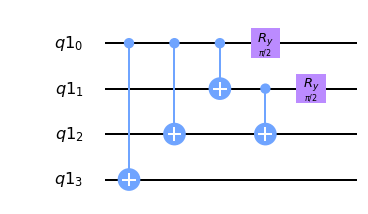

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
q = QuantumRegister(4)
qc = QuantumCircuit(q)

qc.cx(0,3)
qc.cx(0,2)
qc.cx(0,1)
qc.ry(np.pi/2,0)
qc.cx(1,2)
qc.ry(np.pi/2,1)

display(qc.draw(output='mpl'))
run_circuit(qc,q)

## Plain protocol <a class="anchor" id="protocol"></a>

In [9]:
#0000
basis0 = {'0000':0,'0001':0,'0010':0,'0011':0,
          '1000':1,'1001':1,'1010':1,'1011':1,
         '0100':2,'0101':2,'0110':2,'0111':2,
         '1100':3,'1101':3,'1110':3,'1111':3}
#1111
basis1 = {'0000':0,'0100':0,'1000':0,'1100':0,
          '0001':1,'0101':1,'1001':1,'1101':1,
         '0011':2,'0111':2,'1011':2,'1111':2,
         '0010':3,'0110':3,'1010':3,'1110':3}
#0110
basis2 = {'0000':0,'0001':0,'0100':0,'0101':0,
          '1000':1,'1001':1,'1100':1,'1101':1,
         '0010':2,'0011':2,'0110':2,'0111':2,
         '1010':3,'1011':3,'1110':3,'1111':3}
#1001
basis3 = {'0000':0,'0011':0,'1000':0,'1011':0,
          '0001':1,'0010':1,'1001':1,'1010':1,
         '0100':2,'0111':2,'1100':2,'1111':2,
         '0101':3,'0110':3,'1101':3,'1110':3}

N = 100

keyA = np.random.randint(2, size=N)
keyB = np.random.randint(2, size=N)
keyC1 = np.random.randint(2, size=N)
keyC2 = np.random.randint(2, size=N)

basisA = np.random.randint(2, size=N)
basisB = np.random.randint(2, size=N)
basisC1 = np.random.randint(2, size=N)
basisC2 = np.random.randint(2, size=N)

dataA = np.zeros(0, dtype=int)
dataB = np.zeros(0, dtype=int)
dataC1 = np.zeros(0, dtype=int)
dataC2 = np.zeros(0, dtype=int)

case = np.zeros(N)

for i in range(N):

    q = QuantumRegister(4,'p')
    qm = QuantumRegister(4, 'm')
    key = ClassicalRegister(4,'key')
    cloning = QuantumRegister(2,'cloning')
    infoE = ClassicalRegister(1, 'infoE')
    qc = QuantumCircuit(q,qm,cloning,key,infoE)

    #choose bases, bits
    if(keyA[i] == 1):
        qc.x(0)
    if(keyB[i] == 1):
        qc.x(1)
    if(keyC1[i] == 1):
        qc.x(2)
    if(keyC2[i] == 1):
        qc.x(3)
    
    if(basisA[i] == 1):
        qc.ry(-np.pi/2,0)
    if(basisB[i] == 1):
        qc.ry(-np.pi/2,1)
    if(basisC1[i] == 1):
        qc.ry(-np.pi/2,2)
    if(basisC2[i] == 1):
        qc.ry(-np.pi/2,3)
        
    
    qc.barrier(q,qm)

    #swap to eve

    #swap to m
    qc.swap(0,4)
    qc.swap(1,5)
    qc.swap(2,6)
    qc.swap(3,7)
    qc.barrier(q,qm)


    #prepare measurement
    qc.cx(4,7)
    qc.cx(4,6)
    qc.cx(4,5)
    qc.h(4)
    qc.cx(5,6)
    qc.h(5)

    qc.barrier(qm)

    #measurement
    qc.measure(4,0)
    qc.measure(5,1)
    qc.measure(6,2)
    qc.measure(7,3)
    
    job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1)
    result = job.result()
    counts = result.get_counts()
    
    k = list(counts.keys())[0]
    k = k[2:6]
    #k = ' '.join(k)
    dataM = np.fromstring(k,sep=' ', dtype=int)
    
    if(basisA[i] == 0 and basisB[i] == 0 and basisC1[i] == 0 and basisC2[i] == 0):
        case[i] = basis0[k]
    elif(basisA[i] == 1 and basisB[i] == 1 and basisC1[i] == 1 and basisC2[i] == 1):
        case[i] = basis1[k]
    elif(basisA[i] == 0 and basisB[i] == 1 and basisC1[i] == 1 and basisC2[i] == 0):
        case[i] = basis2[k]
    elif(basisA[i] == 1 and basisB[i] == 0 and basisC1[i] == 0 and basisC2[i] == 1):
        case[i] = basis3[k]
    else:
        case[i] = 4
    
    if(case[i] == 0):
        if(keyC1[i]!=keyC2[i]):
            keyC2[i] = 1 - keyC2[i]
            keyA[i] = 1 - keyA[i]
    elif(case[i] == 1):
        if(keyC1[i]!=keyC2[i]):
            keyC2[i] = 1 - keyC2[i]
        else:
            keyA[i] = 1 - keyA[i]
    elif(case[i] == 2):
        if(keyC1[i]!=keyC2[i]):
            keyC1[i] = 1 - keyC1[i]
        else:
            keyB[i] = 1 - keyB[i]
    elif(case[i] == 3):
        if(keyC1[i]!=keyC2[i]):
            keyB[i] = 1 - keyB[i]
            keyC2[i] = 1 - keyC2[i]
        else:
            keyA[i] = 1 - keyA[i]
            keyB[i] = 1 - keyB[i] 

    if(case[i]!=4):
        dataA = np.append(dataA,keyA[i])
        dataB = np.append(dataB,keyB[i])
        dataC1 = np.append(dataC1,keyC1[i])
        dataC2 = np.append(dataC2,keyC2[i])
#cplot=qc.draw(output='mpl')
#display(cplot)

print('dataA: ', dataA)
print('dataB: ', dataB)
print('dataC1:', dataC1)
print('dataC2:', dataC2)

dataA:  [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1]
dataB:  [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1]
dataC1: [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1]
dataC2: [1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1]


## Working protocol with Eavesdropper <a class="anchor" id="eve"></a>

In [19]:
#Code with Eve
N = 100
chanceE = 0.5   # Chance Eve drops (1 = 100%)
print_table = True

# Setup
basisA = np.random.randint(2, size=N)   # 0 means 0/1 basis, 1 means +/-
basisB = np.random.randint(2, size=N)
basisE = np.random.choice([0,1,2], p=[0.5*chanceE, 0.5*chanceE, 1-chanceE], size=N)

dataA = np.random.randint(2, size=N)
dataB = np.random.randint(2, size=N)
dataC = np.zeros((2,N), dtype=int)
dataE = np.zeros(N, dtype=int)

A = QuantumRegister(1, name = 'alice')
B = QuantumRegister(1, name = 'bob')
C = QuantumRegister(2, name = 'charlie')
E = QuantumRegister(1, 'eve')
cr = ClassicalRegister(2, name = 'c')
infoE = ClassicalRegister(1, "infoEve")

keyA = np.zeros(N, dtype=int)
keyB = np.zeros(N, dtype=int)
M = 0  # counter for key

if print_table:
    print(' bit A B  | result E |  result  C   | bitflip? ')
    print('--------------------------------------------------')

# Build and run the circuits
for i in range(N):
    circuit = QuantumCircuit(A, B, C, E, cr, infoE)
    if(dataA[i] == 1):    
        circuit.x(A)
    if(dataB[i] == 1):    
        circuit.x(B)
    if(basisA[i] == 1):    
        circuit.ry(np.pi/2,0)
    if(basisB[i] == 1):    
        circuit.ry(np.pi/2,1)
    
    # Eve drops (or doesnt)
    circuit.barrier(A,B,C,E)
    if basisE[i] == 0:
        circuit.swap(A[0], E[0])
        circuit.measure(E[0], infoE[0])
        circuit.swap(A[0], E[0])
    elif basisE[i] == 1:
        circuit.swap(A[0], E[0])
        circuit.ry(-np.pi/2, E[0])
        circuit.measure(E[0], infoE[0])
        circuit.ry(np.pi/2, E[0])
        circuit.swap(A[0], E[0])
    circuit.barrier(A,B,C,E)
    
    circuit.swap(A,C[0])
    circuit.swap(B,C[1])
    
    # Charlie performs BSM
    circuit.cx(C[0],C[1])
    circuit.ry(-np.pi/2, C[0])
    circuit.measure(C[0],cr[0])
    circuit.measure(C[1],cr[1])
    
    # Run circuit
    backend = BasicAer.get_backend('qasm_simulator')
    shots = 1
    results = execute(circuit, backend=backend, shots=shots).result()
    counts = results.get_counts()
    k = list(counts.keys())[0]
    k = ' '.join(k)
    data = np.fromstring(k,sep=' ', dtype=int)
    dataE[i] = data[0]
    dataC[:,i] = data[1:]
    
    # Do bit flip if necessary
    bitflip = ''
    if basisA[i] == basisB[i]: 
        keyA[M] = dataA[i]
        keyB[M] = dataB[i]
        bitflip = 'no '
        if basisA[i] == 0 and (list(dataC[:,i]) == [1,0] or list(dataC[:,i]) == [1,1]):
            bitflip = 'yes'
            keyB[M] = 1-keyB[M]
        if basisA[i] == 1 and (list(dataC[:,i]) == [0,1] or list(dataC[:,i]) == [1,1]):
            bitflip = 'yes'
            keyB[M] = 1-keyB[M]
        M += 1
            
    bitA = give_bit(basisA[i], dataA[i])
    bitB = give_bit(basisB[i], dataB[i])
    bitE = give_bit(basisE[i], dataE[i])

    if print_table: 
        print('   {0} {1}    |    {2}     |     {3}    |    {4}'.format(bitA, bitB, bitE, dataC[:,i], bitflip))
    else:
        # Show progress 
        print('Currently at: {0}/{1}  :  {2}%'.format(i+1, N, int(float((i+1))*100/N)))
        clear_output(wait=True)

keyA = keyA[0:M]
keyB = keyB[0:M]
QBER = np.sum(keyA != keyB)
print('QBER: {0}%'.format(int(QBER/M*100)))


 bit A B  | result E |  result  C   | bitflip? 
--------------------------------------------------
   - 0    |          |     [1 1]    |    
   0 1    |          |     [1 0]    |    yes
   + +    |    0     |     [0 1]    |    yes
   - 1    |    0     |     [1 1]    |    
   - +    |    -     |     [1 1]    |    yes
   0 1    |    0     |     [1 0]    |    yes
   + -    |          |     [1 1]    |    yes
   0 -    |          |     [1 1]    |    
   0 +    |          |     [0 0]    |    
   0 +    |          |     [1 0]    |    
   + -    |          |     [1 1]    |    yes
   + +    |    0     |     [1 1]    |    yes
   - +    |    -     |     [1 1]    |    yes
   + 0    |          |     [0 0]    |    
   0 1    |    0     |     [1 0]    |    yes
   1 0    |    +     |     [1 1]    |    yes
   - -    |    1     |     [0 1]    |    yes
   0 0    |    +     |     [1 0]    |    yes
   - 0    |    -     |     [1 0]    |    
   0 0    |    0     |     [0 0]    |    no 
   1 -    |    1     |

## Protocol on NV with Noise <a class="anchor" id="noise"></a>

Below the circuit is implemented with noise. A simplification is made by letting Charlie keep their bits and letting all others send theirs to Charlie. This drastically reduces the amount noise due to electron-photon interaction and due to relaxation.

0.6253


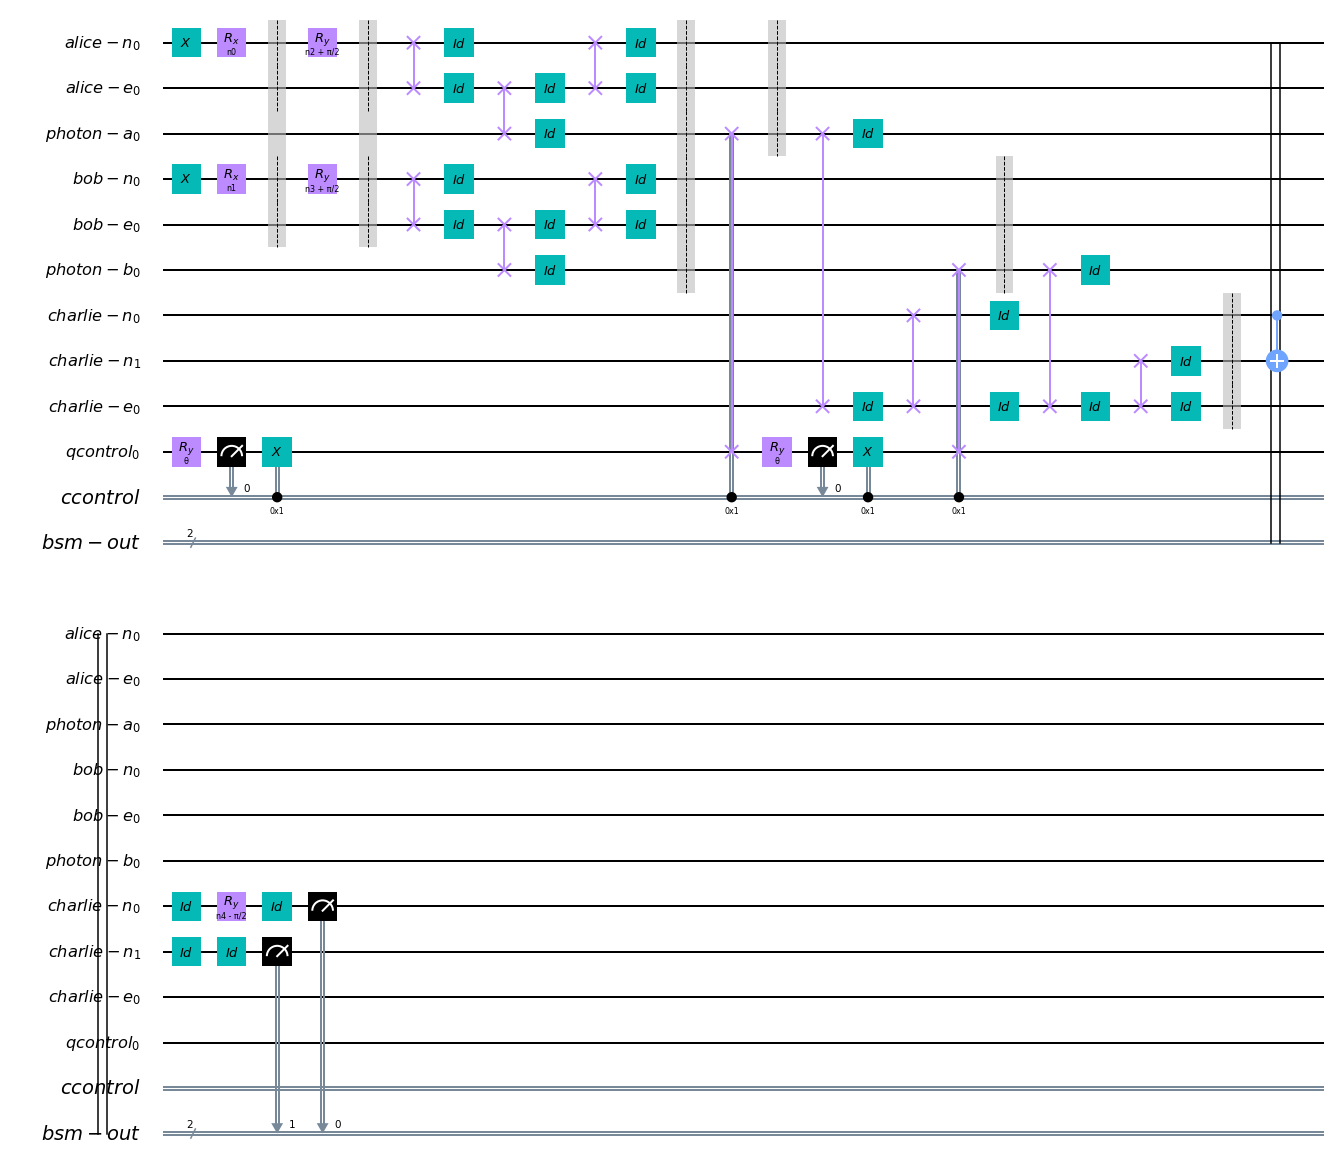

In [37]:
possibilities = [(0,0,0),(0,0,1),(0,1,0),(0,1,1),(1,0,0),(1,0,1),(1,1,0),(1,1,1),
                (2,2,2),(2,2,3),(2,3,2),(2,3,3),(3,2,2),(3,2,3),(3,3,2),(3,3,3),]

noises_n = [np.linspace(0,0.063,5), 0.063, 0.063, 0.063, 0.063, 0.063]
noises_e = [0.201, np.linspace(0,0.201,5), 0.201, 0.201, 0.201, 0.201]
noises_l = [0.05, 0.05, np.linspace(0,0.05,5), 0.05, 0.05, 0.05]
noises_depo = [0.02, 0.02, 0.02, np.linspace(0,0.02,5), 0.02, 0.02]
noises_deph = [0.01, 0.01, 0.01, 0.01, np.linspace(0,0.01,5), 0.01]
noises_meas = [0.05, 0.05, 0.05, 0.05, 0.05, np.linspace(0,0.05,5)]

results = [[[[None for i in range(20)] for k in range(5)] for l in range(16)] for m in range(6)]

for noise_type in range(6):
    for i, p in enumerate(possibilities):

        # Create the circuit
        # Registers for Alice, Bob and two for Charlie
        An = QuantumRegister(1, 'alice-n')
        Ae = QuantumRegister(1, 'alice-e')
        Bn = QuantumRegister(1, 'bob-n')
        Be = QuantumRegister(1, 'bob-e')
        Cn = QuantumRegister(4, 'charlie-n')
        Ce = QuantumRegister(1, 'charlie-e')

        # Communication lines via photons
        Ap = QuantumRegister(1, 'alice-photon')
        Bp = QuantumRegister(1, 'bob-photon')
        #raw key
        Mc = ClassicalRegister(4, 'raw key')

        #control lines for the attenuation
        control = QuantumRegister(2,'qcontrol')
        initA = ClassicalRegister(1,'ccontrolA')
        initB = ClassicalRegister(1,'ccontrolB')


        qc = QuantumCircuit(An, Ae, Bn, Be, Cn, Ce, Ap, Bp, Mc, control, initA, initB)

        build_circuit(p[0],p[1],p[2])
        
        theta_val = 2*np.arccos(np.exp(-length/(2*att_length)))

        number_picks = 20
        N = 100

        backend = Aer.get_backend('qasm_simulator')
        for noise in range(5):
            for randpick in range(number_picks):
                # Choose a random noise for the carbon and electron gates
                if(noise_type == 0):
                    n0 = np.random.normal(scale=noises_n[noise_type][noise])
                    n1 = np.random.normal(scale=noises_n[noise_type][noise])
                    nh1 = np.random.normal(scale=noises_n[noise_type][noise])
                    nh2 = np.random.normal(scale=noises_n[noise_type][noise])
                else:
                    n0 = np.random.normal(scale=noises_n[noise_type])
                    n1 = np.random.normal(scale=noises_n[noise_type])
                    nh1 = np.random.normal(scale=noises_n[noise_type])
                    nh2 = np.random.normal(scale=noises_n[noise_type])

                if(noise_type == 1):
                    e0 = np.random.normal(scale=noises_e[noise_type][noise])
                else:
                    e0 = np.random.normal(scale=noises_e[noise_type])

                noisemodel = NoiseModel()
                if(noise_type == 3):
                    depo = errors.depolarizing_error(noises_depo[noise_type][noise], 1)
                else:
                    depo = errors.depolarizing_error(noises_depo[noise_type], 1)

                if(noise_type == 2):
                    theta_val = 2*np.arccos(np.exp(-noises_l[noise_type][noise]/(2*att_length)))
                else:
                    theta_val = 2*np.arccos(np.exp(-noises_l[noise_type]/(2*att_length)))

                if(noise_type == 4):
                    deph = errors.phase_damping_error(noises_deph[noise_type][noise],1)
                else:
                    deph = errors.phase_damping_error(noises_deph[noise_type],1)

                if(noise_type == 5):
                    depo_meas = errors.depolarizing_error(noises_meas[noise_type][noise], 1)
                else:
                    depo_meas = errors.depolarizing_error(noises_meas[noise_type], 1)

                noisemodel = NoiseModel()
                noisemodel.add_all_qubit_quantum_error(depo,'Cswap')
                noisemodel.add_all_qubit_quantum_error(deph,'eswap')
                noisemodel.add_all_qubit_quantum_error(meas,'meas')

                if(p[0] == 0):
                    if(p[1] == 0):
                        if(p[2] == 0):
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})
                        else:
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_Cn1: nC1, noise_Cn2: nC2,
                                              noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})
                    else:
                        if(p[2] == 0):
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_Bn: nB,
                                              noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})
                        else:
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_Bn: nB, noise_Cn1: nC1, noise_Cn2: nC2,
                                              noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})
                else:
                    if(p[1] == 0):
                        if(p[2] == 0):
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_h1: nh1, noise_h2: nh2, noise_An: nA,
                                              theta_An:theta_val, theta_Bn:theta_val})
                        else:
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_An: nA, noise_Cn1: nC1, noise_Cn2: nC2,
                                              noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})
                    else:
                        if(p[2] == 0):
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_An: nA, noise_Bn: nB,
                                              noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})
                        else:
                            circuit = qc.bind_parameters({pi_par: np.pi, noise_An: nA, noise_Bn: nB, noise_Cn1: nC1, noise_Cn2: nC2,
                                              noise_h1: nh1, noise_h2: nh2,
                                              theta_An:theta_val, theta_Bn:theta_val})

                # Execute the circuit and save the qber
                job = execute(circuit, backend=backend, shots=N, noise_model=noisemodel)
                result = job.result()
                counts = result.get_counts()

                results[noise_type][i][noise][randpick] = counts

                # Show progress 
                print('Currently at: {0}/{1}'.format(randpick+1+20*(i+5*(noise+6*noise_type)), 3720))
                clear_output(wait=True)

    

Get the results without noise to compare

In [ ]:
result_noiseless = [None]*16
for i, p in enumerate(possibilities):
    # Create the circuit
    # Registers for Alice, Bob and two for Charlie
    An = QuantumRegister(1, 'alice-n')
    Ae = QuantumRegister(1, 'alice-e')
    Bn = QuantumRegister(1, 'bob-n')
    Be = QuantumRegister(1, 'bob-e')
    Cn1 = QuantumRegister(1, 'charlie-n-1')
    Ce1 = QuantumRegister(1, 'charlie-e-1')
    Cn2 = QuantumRegister(1, 'charlie-n-2')
    Ce2 = QuantumRegister(1, 'charlie-e-2')
    # Communication lines via photons
    Ap = QuantumRegister(1, 'alice-photon')
    Bp = QuantumRegister(1, 'bob-photon')
    Cp1 = QuantumRegister(1, 'charlie-photon-1')
    Cp2 = QuantumRegister(1, 'charlie-photon-2')
    # Classical and quantum register for the central measurer
    Me = QuantumRegister(1, 'e-central-measurer')
    Mn = QuantumRegister(4, 'n-centeral-measurer')
    Mc = ClassicalRegister(4, 'raw key')

    #control lines for the attenuation
    control = QuantumRegister(4,'qcontrol')
    initA = ClassicalRegister(1,'ccontrolA')
    initB = ClassicalRegister(1,'ccontrolB')
    initC1 = ClassicalRegister(1,'ccontrolC1')
    initC2 = ClassicalRegister(1,'ccontrolC2')


    qc = QuantumCircuit(An, Ae, Bn, Be, Cn, Ce, Ap, Bp, Mc, control, initA, initB)
    
    
    
    build_circuit(p[0],p[1],p[2])
    noise_n = 0   # The 1-sigmas that will be used on carbon gates
    noise_e = 0   # The 1-sigmas that will be used on electron gates
    att_length = 0.542
    length = 0
    theta_val = 2*np.arccos(np.exp(-length/(2*att_length)))
    nA = 0
    nB = 0
    nC1 = 0
    nC2 = 0
    nh1 = 0
    nh2 = 0


    number_picks = 1
    N = 100

    backend = Aer.get_backend('qasm_simulator')
    
    if(p[0] == 0):
        if(p[1] == 0):
            if(p[2] == 0):
                circuit = qc.bind_parameters({pi_par: np.pi, noise_h1: 0, noise_h2: 0,
                                  theta_An:theta_val, theta_Bn:theta_val})
            else:
                circuit = qc.bind_parameters({pi_par: np.pi, noise_Cn1: nC1, noise_Cn2: nC2,
                                  noise_h1: nh1, noise_h2: nh2,
                                  theta_An:theta_val, theta_Bn:theta_val})
        else:
            if(p[2] == 0):
                circuit = qc.bind_parameters({pi_par: np.pi, noise_Bn: nB,
                                  noise_h1: nh1, noise_h2: nh2,
                                  theta_An:theta_val, theta_Bn:theta_val})
            else:
                circuit = qc.bind_parameters({pi_par: np.pi, noise_Bn: nB, noise_Cn1: nC1, noise_Cn2: nC2,
                                  noise_h1: nh1, noise_h2: nh2,
                                  theta_An:theta_val, theta_Bn:theta_val})
    else:
        if(p[1] == 0):
            if(p[2] == 0):
                circuit = qc.bind_parameters({pi_par: np.pi, noise_h1: nh1, noise_h2: nh2, noise_An: nA,
                                  theta_An:theta_val, theta_Bn:theta_val})
            else:
                circuit = qc.bind_parameters({pi_par: np.pi, noise_An: nA, noise_Cn1: nC1, noise_Cn2: nC2,
                                  noise_h1: nh1, noise_h2: nh2,
                                  theta_An:theta_val, theta_Bn:theta_val})
        else:
            if(p[2] == 0):
                circuit = qc.bind_parameters({pi_par: np.pi, noise_An: nA, noise_Bn: nB,
                                  noise_h1: nh1, noise_h2: nh2,
                                  theta_An:theta_val, theta_Bn:theta_val})
            else:
                circuit = qc.bind_parameters({pi_par: np.pi, noise_An: nA, noise_Bn: nB, noise_Cn1: nC1, noise_Cn2: nC2,
                                  noise_h1: nh1, noise_h2: nh2,
                                  theta_An:theta_val, theta_Bn:theta_val})
                    
    job = execute(circuit, backend=backend, shots=N)
    result = job.result()
    counts = result.get_counts()

    result_noiseless[i] = counts


In [1]:
qber = [[0 for i in range(5)] for k in range(6)]

for nt in range(6):
    for k in range(5):
        for i in range(16):
            qbernon[i] = 0
            keys = list(result_noiseless[i].keys())
            for r in range(20):
                for s in strings:
                    try:
                        qbernon[i] += results[nt][i][k][r][s+str(keys[0])[3:]]
                    except:pass
                    try:
                        qbernon[i] += results[nt][i][k][r][s+str(keys[1])[3:]]
                    except:pass
                    try:
                        qbernon[i] += results[nt][i][k][r][s+str(keys[2])[3:]]
                    except:pass
                    try:
                        qbernon[i] += results[nt][i][k][r][s+str(keys[3])[3:]]
                    except:pass
        #         print(results[0][i][k][r])
        qber[nt][k] = 1-(np.mean(qbernon))/2000

labels = ['Carbon', 'electron', 'length', 'depolarizing carbon-electron', 'dephasing electron-photon', 'depolarizing measurement']

for i, l in enumerate(labels):
    plt.plot(np.linspace(0,1,5),qber[i],ls='--',label=l)


#ax.plot(np.mean(noises[index],axis=0), linewidth=3.0,label='avg')
plt.ylabel('qber')
plt.xlabel('fraction of default parameter')
plt.legend()

NameError: name 'qbernon' is not defined